# Business Case 4: Cryptocurrencies Forecasting

## Contents:
  
 * [Modeling AXS](#Modeling)
 * [AXS - Entire Dataset](#entiredataset)
    * [Model 1: LSTM](#lstm)
    * [Model 2: XGBOOST Regressor](#xgboost)
 * [AXS - since January 2021](#jan2021)
    * [Model 1: LSTM](#lstm2)
    * [Model 2: XGBOOST Regressor](#xgboost2)
 * [AXS - since January 2022](#jan2022)
    * [Model 1: LSTM](#lstm3)
    * [Model 2: XGBOOST Regressor](#xgboost3)
 * [Predictions for the next two days using the best model](#predictions)
 * [Final Predictions](#finalpredictions)

## Imports

In [1]:
#! pip install xgboost
#! pip install fastai==0.7.0
#! pip install --upgrade tensorflow
#! pip install keras
#! pip install pystan
#! pip install ephem
#! pip install fbprophet

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from math import ceil
import math
import scipy.stats as stats
from itertools import cycle

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly

import json
import requests
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error , mean_absolute_error, explained_variance_score, r2_score
from tensorflow.keras import layers
from xgboost import XGBRegressor

import warnings

# Modeling - AXS <a name="Modeling"></a>
>In this step, we decided to implement algorithms (LSTM, XGBOOST Regressor) that can predict the closing price of AXS.

# AXS - Entire Dataset <a name="entiredataset"></a>

In [3]:
axs = pd.read_csv('AXS.csv', index_col = 'Date')

In [4]:
axs.head()

,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close,BTC_closeprice
Date,,,,,,,,
2020-11-19,0.000425,0.001287,0.670093,0.001930,0.224814,0.994353,0.683536,0.014045
2020-11-20,0.000789,0.002080,0.663081,0.001688,0.246063,0.997718,0.695617,0.029983
2020-11-21,0.000615,0.001171,0.626054,0.000912,0.143100,0.996813,0.695617,0.030398
2020-11-22,0.000367,0.001227,0.594672,0.000659,0.128375,0.997948,0.695617,0.025003
2020-11-23,0.000885,0.001905,0.574128,0.002146,0.300778,0.998414,0.695617,0.024886


# Model 1: LSTM <a name="lstm"></a>

In [5]:
data = axs.copy()

In [6]:
data.head()

,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close,BTC_closeprice
Date,,,,,,,,
2020-11-19,0.000425,0.001287,0.670093,0.001930,0.224814,0.994353,0.683536,0.014045
2020-11-20,0.000789,0.002080,0.663081,0.001688,0.246063,0.997718,0.695617,0.029983
2020-11-21,0.000615,0.001171,0.626054,0.000912,0.143100,0.996813,0.695617,0.030398
2020-11-22,0.000367,0.001227,0.594672,0.000659,0.128375,0.997948,0.695617,0.025003
2020-11-23,0.000885,0.001905,0.574128,0.002146,0.300778,0.998414,0.695617,0.024886


In [7]:
#Splitting the original dataset using all the variables (hist) and "close" (target) using 7 days a the length of the sliding window

hist = []
target = []
length = 7

for i in range(len(data)-length):
    t = data['close']
    v = data[['close', 'volume', 'spread', 'BTC_closeprice','volatility', 'close_off_high', 'EUR/USD_close']]
    x = v[i:i+length]
    y = t[i+length]
    hist.append(x)
    target.append(y)

In [8]:
print(len(hist[0]))  #nr of days
print(len(hist)) #size of train dataset
print(len(target)) #size of test dataset

7
516
516


In [9]:
#convert lists to arrays
hist = np.array(hist)
target = np.array(target)

In [10]:
target = target.reshape(-1,1)
target.shape

(516, 1)

In [11]:
#Splitting the datasets into train and test using 80% for train and 20% for test

training_size=int(len(data)*0.80)

X_train = hist[:training_size,:]
X_test = hist[training_size:,:]

y_train = target[:training_size]
y_test = target[training_size:]

In [12]:
#Nr of instances, # nr of days (length), #nr of columns
X_train.shape

(418, 7, 7)

In [13]:
model = tf.keras.Sequential()

model.add(layers.LSTM(units=20, activation = 'relu', return_sequences=True,
                  input_shape=(7,7), dropout = 0.2))

model.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model.add(layers.LSTM(units=40, activation = 'relu', dropout=0.2))

#model.add(layers.LSTM(units=55, return_sequences = True, dropout = 0.2))

#model.add(layers.LSTM(units = 80, activation = 'relu', dropout = 0.2))

model.add(layers.Dense(units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 20)             2240      
                                                                 
 lstm_1 (LSTM)               (None, 7, 32)             6784      
                                                                 
 lstm_2 (LSTM)               (None, 40)                11680     
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 20,745
Trainable params: 20,745
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, shuffle = False, validation_split=0.2)

Epoch 1/30
11/11 [==============================] - 4s 80ms/step - loss: 0.0681 - val_loss: 0.4491
Epoch 2/30
11/11 [==============================] - 0s 14ms/step - loss: 0.0536 - val_loss: 0.3563
Epoch 3/30
11/11 [==============================] - 0s 12ms/step - loss: 0.0491 - val_loss: 0.2815
Epoch 4/30
11/11 [==============================] - 0s 13ms/step - loss: 0.0503 - val_loss: 0.2385
Epoch 5/30
11/11 [==============================] - 0s 13ms/step - loss: 0.0475 - val_loss: 0.2046
Epoch 6/30
11/11 [==============================] - 0s 12ms/step - loss: 0.0430 - val_loss: 0.1629
Epoch 7/30
11/11 [==============================] - 0s 12ms/step - loss: 0.0339 - val_loss: 0.0982
Epoch 8/30
11/11 [==============================] - 0s 16ms/step - loss: 0.0260 - val_loss: 0.0341
Epoch 9/30
11/11 [==============================] - 0s 14ms/step - loss: 0.0184 - val_loss: 0.0049
Epoch 10/30
11/11 [==============================] - 0s 11ms/step - loss: 0.0185 - val_loss: 0.0069
Epoch 11/

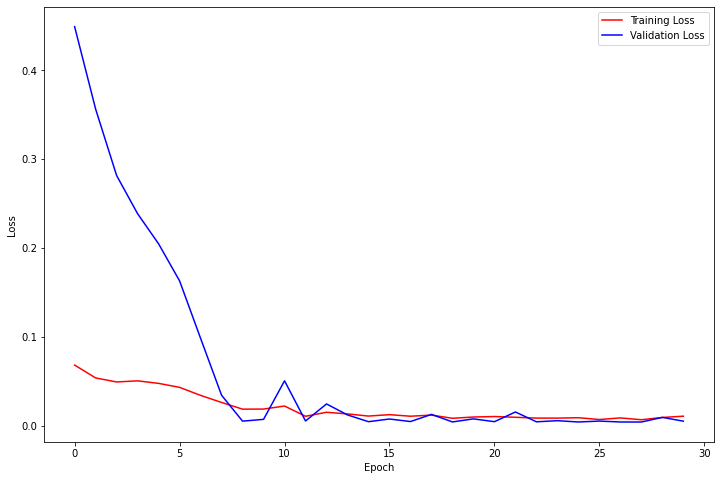

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_count = range(len(loss))
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r', label='Training loss')
plt.plot(epoch_count, val_loss, 'b', label='Validation loss')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [17]:
pred_test = model.predict(X_test)
pred_train = model.predict (X_train)

In [18]:
results = np.concatenate((y_test, pred_test), axis=1)
results = pd.DataFrame(results, columns = ['y_test', 'Predictions'])
a = data['close'].tail(len(pred_test))
a = list(a.index)
results['Date'] = a
results['Date'] = pd.to_datetime(results['Date'])
results.tail()

,y_test,Predictions,Date
93,0.279568,0.358740,2022-04-21
94,0.284981,0.361467,2022-04-22
95,0.280089,0.360521,2022-04-23
96,0.275019,0.358784,2022-04-24
97,0.266291,0.360158,2022-04-25


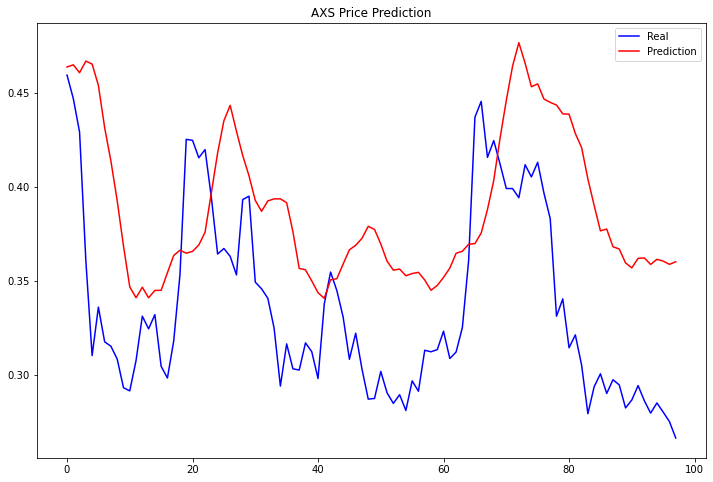

In [19]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred_test, color='red', label='Prediction')
plt.title('AXS Price Prediction')
plt.legend()
plt.show()

In [20]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,pred_train)))
print("Train data MSE: ", mean_squared_error(y_train,pred_train))
print("Train data MAE: ", mean_absolute_error(y_train,pred_train))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,pred_test)))
print("Test data MSE: ", mean_squared_error(y_test,pred_test))
print("Test data MAE: ", mean_absolute_error(y_test,pred_test))

Train data RMSE:  0.0555532645552378
Train data MSE:  0.0030861652027442403
Train data MAE:  0.03182980821874041
-------------------------------------------------------------------------------------
Test data RMSE:  0.0673782555997372
Test data MSE:  0.004539829327663518
Test data MAE:  0.059612785962189496


In [21]:
print("Train data R2 score:", r2_score(y_train, pred_train))
print("Test data R2 score:", r2_score(y_test, pred_test))

Train data R2 score: 0.9682310937450955
Test data R2 score: -0.8656469403131433


# Model 2: XGBoost Regressor  <a name="xgboost"></a>

In [22]:
data1 = axs.copy()
data1.reset_index(inplace = True)
data1.shape

(523, 9)

In [23]:
close_stock = data1.copy()
print("Total data for prediction: ",data1.shape[0])

Total data for prediction:  523


In [24]:
data1.set_index('Date', inplace = True)
data1.shape

(523, 8)

In [25]:
#Train and test split using 80% for train and 20% for test
training_size=int(len(data1)*0.80)
test_size=len(data1)-training_size
train_data,test_data=data1.iloc[:training_size,:],data1.iloc[training_size:,:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (418, 8)
test_data:  (105, 8)


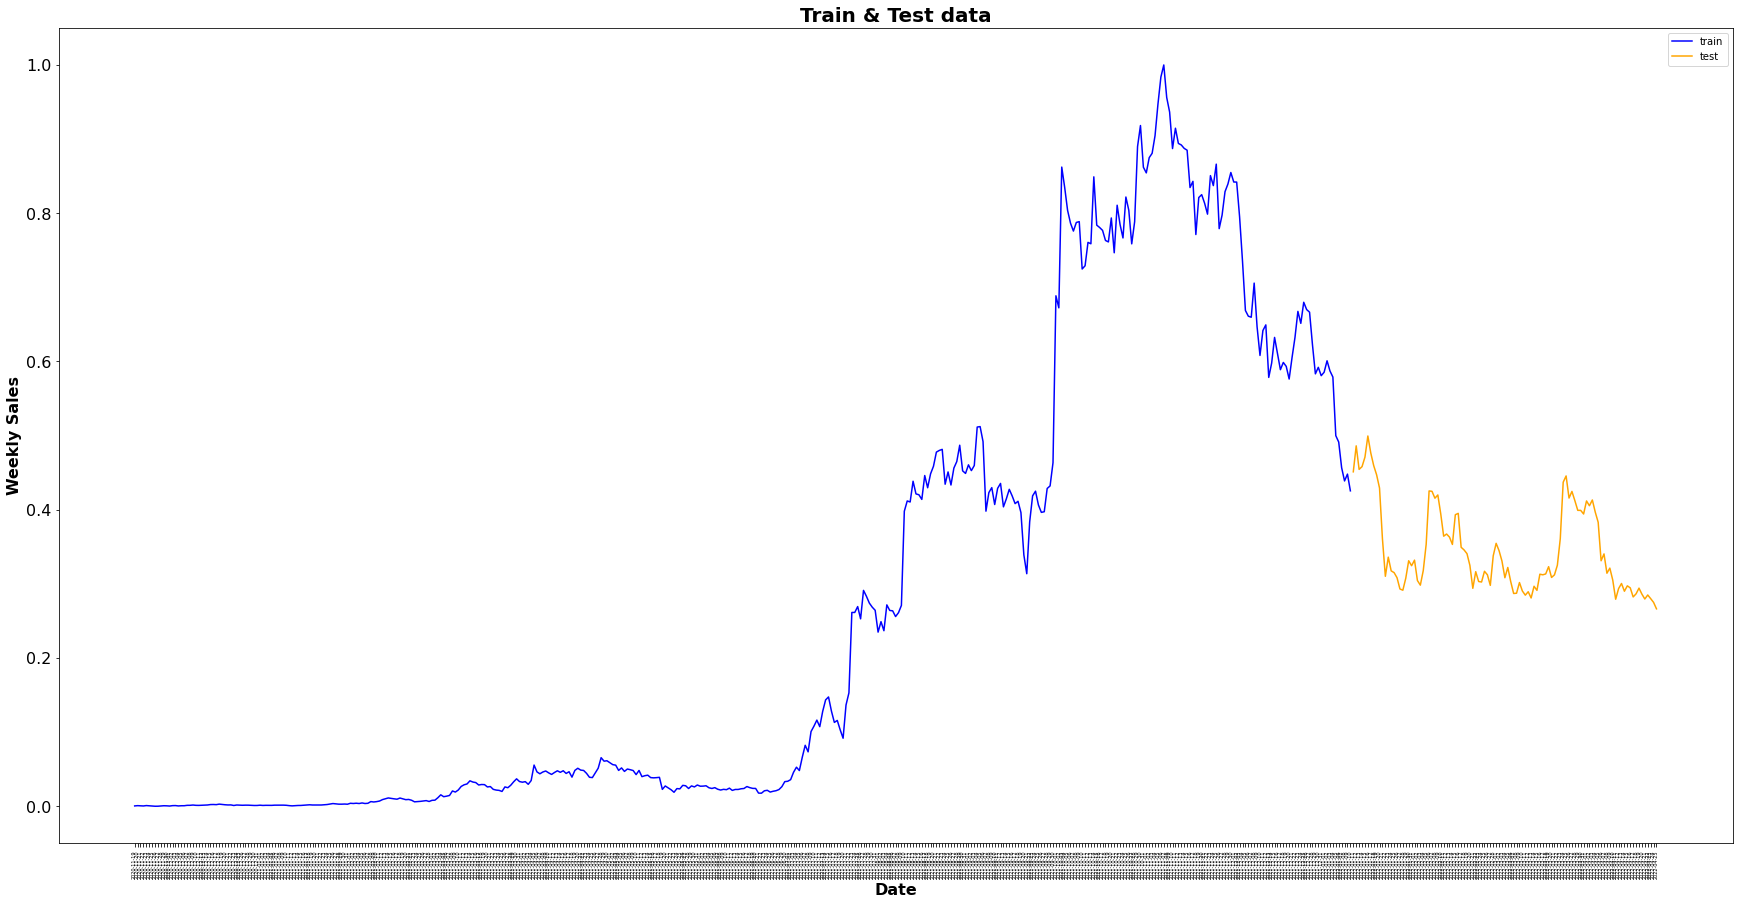

In [26]:
data1.reset_index(inplace = True)
fig, ax = plt.subplots(figsize=(30, 15))
sns.lineplot(x = close_stock['Date'][:training_size], y = close_stock['close'][:training_size], color = 'blue')
sns.lineplot(x = close_stock['Date'][training_size:], y = close_stock['close'][training_size:], color = 'orange')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', labelsize=5)
plt.xticks(rotation='vertical')
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [27]:
data1.set_index('Date', inplace = True)

In [28]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step), 1:]   
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [29]:
#Sliding window = 7 or 20
time_step = 7
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (410, 7, 7)
y_train:  (410,)
X_test:  (97, 7, 7)
y_test (97,)


In [30]:
#Reshaping the arrays because XGBRegressor only accepts 1-Dimensional arrays
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [31]:
model1 = XGBRegressor(n_estimators=100, random_state = 1, eta = 0.2)
model1.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.200000003, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=1, reg_alpha=0, ...)

In [32]:
predictions = model1.predict(X_test).reshape(-1,1)
y_test = y_test.reshape(-1,1)

predictions_train = model1.predict(X_train)

In [33]:
results2 = np.concatenate((y_test, predictions),axis = 1)
results2 = pd.DataFrame(results2, columns = ['y_test', 'Predictions'])
a = data1['close'].tail(len(predictions))
a = list(a.index)
results2['Date'] = a
results2['Date'] = pd.to_datetime(results2['Date'])
results2.tail()

,y_test,Predictions,Date
92,0.286135,0.550422,2022-04-21
93,0.279568,0.551388,2022-04-22
94,0.284981,0.542915,2022-04-23
95,0.280089,0.545161,2022-04-24
96,0.275019,0.551138,2022-04-25


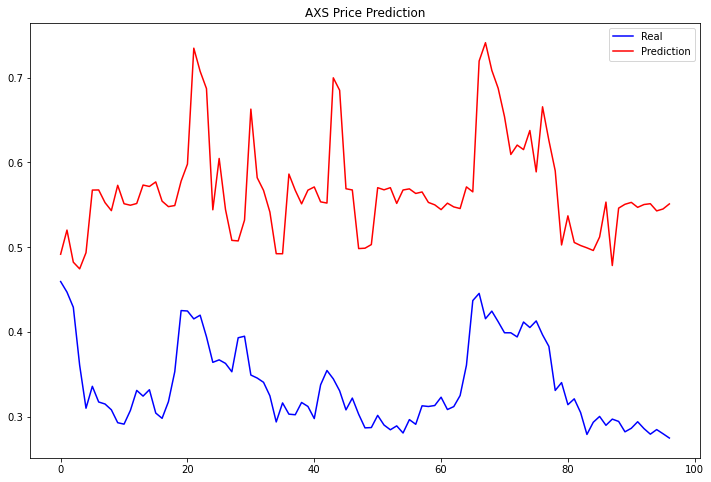

In [34]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(predictions, color='red', label='Prediction')
plt.title('AXS Price Prediction')
plt.legend()
plt.show()

In [35]:
print("Train data MSE: ", mean_squared_error(y_train,predictions_train))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_train, predictions_train)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_train, predictions_train))))
print('R^2 Score', r2_score(y_train, predictions_train))

print ("--------------------------------------------------------------")
print("Test data MSE: ", mean_squared_error(y_test,predictions))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))
print('R^2 Score', r2_score(y_test, predictions))

Train data MSE:  2.985676190930461e-07
Mean Absolute Error - MAE : 0.00038553063105993866
Root Mean squared Error - RMSE : 0.0005464134140859338
R^2 Score 0.999996961724436
--------------------------------------------------------------
Test data MSE:  0.0563522320833984
Mean Absolute Error - MAE : 0.23073890050741902
Root Mean squared Error - RMSE : 0.23738625083057865
R^2 Score -22.410724121097463


# AXS- since January 2021  <a name="jan2021"></a>

# Model 1: LSTM <a name="lstm2"></a>

In [36]:
data2 = axs.copy()
data2.reset_index(inplace = True)
data2 = data2[data2['Date'] >= '2021-01-01']
data2.set_index('Date', inplace = True)
print("Total data for prediction: ",data2.shape[0])

Total data for prediction:  480


In [37]:
hist = []
target = []
length = 7

for i in range(len(data2)-length):
    t = data2['close']
    v = data2[['close','volume','BTC_closeprice','spread', 'volatility', 'close_off_high', 'EUR/USD_close']]
    x = v[i:i+length]
    y = t[i+length]
    hist.append(x)
    target.append(y)

In [38]:
print(len(hist[0]))
print(len(hist))
print(len(target))

7
473
473


In [39]:
#convert list to array
hist = np.array(hist)
target = np.array(target)

In [40]:
target = target.reshape(-1,1)
target.shape

(473, 1)

In [41]:
training_size = int(len(data2)*0.8)

X_train = hist[:training_size,:]
X_test = hist[training_size:,:]

y_train = target[:training_size]
y_test = target[training_size:]

In [42]:
X_train.shape

(384, 7, 7)

In [43]:
model2 = tf.keras.Sequential()

model2.add(layers.LSTM(units=20, activation = 'relu', return_sequences=True,
                  input_shape=(7,7), dropout = 0.2))

model2.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model2.add(layers.LSTM(units=32, activation = 'relu', dropout=0.2))

#model.add(layers.LSTM(units=55, return_sequences = True, dropout = 0.2))

#model.add(layers.LSTM(units = 80, activation = 'relu', dropout = 0.2))

model2.add(layers.Dense(units=1))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 7, 20)             2240      
                                                                 
 lstm_4 (LSTM)               (None, 7, 32)             6784      
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 17,377
Trainable params: 17,377
Non-trainable params: 0
_________________________________________________________________


In [44]:
model2.compile(optimizer='adam', loss='mean_squared_error')

In [45]:
history = model2.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, shuffle = False)

Epoch 1/30
10/10 [==============================] - 4s 73ms/step - loss: 0.1113 - val_loss: 0.3441
Epoch 2/30
10/10 [==============================] - 0s 14ms/step - loss: 0.0847 - val_loss: 0.2568
Epoch 3/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0685 - val_loss: 0.1773
Epoch 4/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0666 - val_loss: 0.1280
Epoch 5/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0681 - val_loss: 0.1055
Epoch 6/30
10/10 [==============================] - 0s 13ms/step - loss: 0.0630 - val_loss: 0.0905
Epoch 7/30
10/10 [==============================] - 0s 12ms/step - loss: 0.0562 - val_loss: 0.0696
Epoch 8/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0428 - val_loss: 0.0386
Epoch 9/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0283 - val_loss: 0.0110
Epoch 10/30
10/10 [==============================] - 0s 12ms/step - loss: 0.0226 - val_loss: 0.0071
Epoch 11/

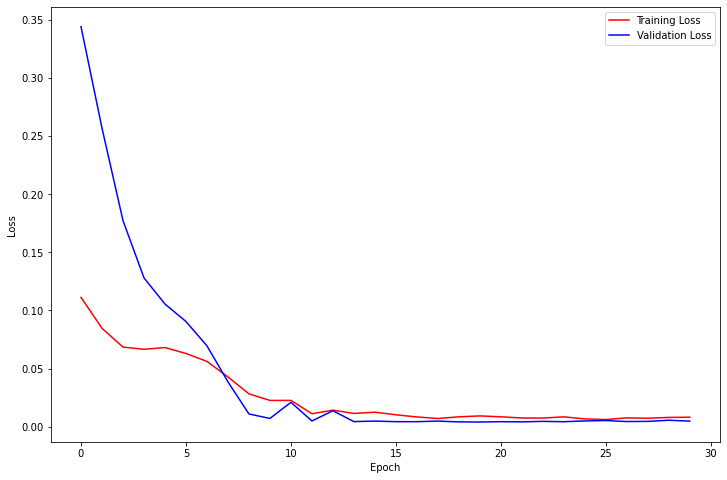

In [46]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_count = range(len(loss))
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r', label='Training loss')
plt.plot(epoch_count, val_loss, 'b', label='Validation loss')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [47]:
pred_test = model2.predict(X_test)
pred_train = model2.predict (X_train)

In [48]:
results = np.concatenate((y_test, pred_test), axis=1)
results = pd.DataFrame(results, columns = ['y_test', 'Predictions'])
a = data2['close'].tail(len(pred_test))
a = list(a.index)
results['Date'] = a
results['Date'] = pd.to_datetime(results['Date'])
results.tail()
results.head()

,y_test,Predictions,Date
0,0.293094,0.418541,2022-01-27
1,0.291400,0.397861,2022-01-28
2,0.307553,0.374522,2022-01-29
3,0.331188,0.359097,2022-01-30
4,0.324449,0.358818,2022-01-31


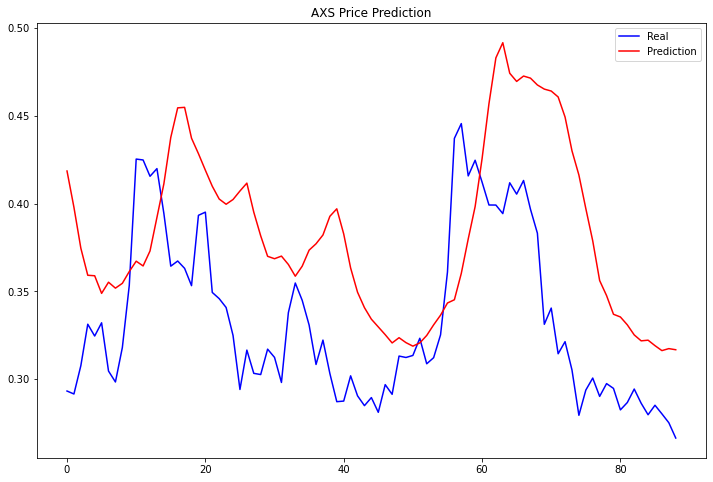

In [49]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred_test, color='red', label='Prediction')
plt.title('AXS Price Prediction')
plt.legend()
plt.show()

In [50]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,pred_train)))
print("Train data MSE: ", mean_squared_error(y_train,pred_train))
print("Train data MAE: ", mean_absolute_error(y_train,pred_train))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,pred_test)))
print("Test data MSE: ", mean_squared_error(y_test,pred_test))
print("Test data MAE: ", mean_absolute_error(y_test,pred_test))

Train data RMSE:  0.0615122509826152
Train data MSE:  0.003783757020948245
Train data MAE:  0.040757790279239085
-------------------------------------------------------------------------------------
Test data RMSE:  0.06802739279740394
Test data MSE:  0.004627726170812286
Test data MAE:  0.058641466224481124


In [51]:
print("Train data R2 score:", r2_score(y_train, pred_train))
print("Test data R2 score:", r2_score(y_test, pred_test))

Train data R2 score: 0.9609663069551512
Test data R2 score: -1.071083270934761


# Model 2: XGBoost Regressor   <a name="xgboost2"></a>

In [52]:
data3 = axs.copy()

In [53]:
data3.reset_index(inplace = True)
data3 = data3[data3['Date'] >= '2021-01-01']               
data3.set_index('Date', inplace = True)
print("Total data for prediction: ",data3.shape[0])

Total data for prediction:  480


In [54]:
data3.shape

(480, 8)

In [55]:
training_size=int(len(data3)*0.80)
test_size=len(data3)-training_size
train_data,test_data=data3.iloc[:training_size,:],data3.iloc[training_size:,:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (384, 8)
test_data:  (96, 8)


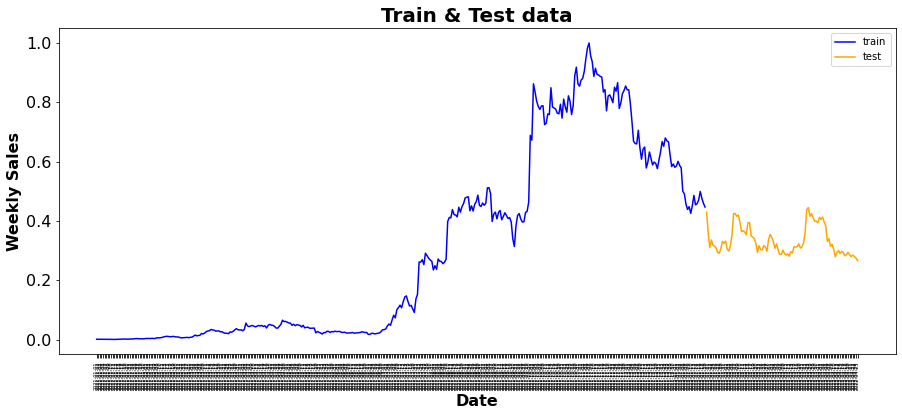

In [56]:
data3.reset_index(inplace = True)
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = data3['Date'][:training_size], y = data3['close'][:training_size], color = 'blue')
sns.lineplot(x = data3['Date'][training_size:], y =data3['close'][training_size:], color = 'orange')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=5)
plt.xticks(rotation = 'vertical')
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [57]:
data3.set_index('Date', inplace = True)

In [58]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step), :]   
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [59]:
time_step = 7
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (376, 7, 8)
y_train:  (376,)
X_test:  (88, 7, 8)
y_test (88,)


In [60]:
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [61]:
model3 = XGBRegressor(n_estimators=1000, random_state = 1, eta = 0.2)
model3.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.200000003, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
             reg_alpha=0, ...)

In [62]:
predictions = model3.predict(X_test).reshape(-1,1)
y_test = y_test.reshape(-1,1)

predictions_train = model3.predict(X_train).reshape(-1,1)
y_train = y_train.reshape(-1,1)

In [63]:
results2 = np.concatenate((y_test, predictions), axis = 1)
results2 = pd.DataFrame(results2, columns = ['y_test', 'Predictions'])
a = data3['close'].tail(len(predictions))
a = list(a.index)
results2['Date'] = a
results2['Date'] = pd.to_datetime(results2['Date'])
results2.tail()

,y_test,Predictions,Date
83,0.286135,0.398215,2022-04-21
84,0.279568,0.341388,2022-04-22
85,0.284981,0.367017,2022-04-23
86,0.280089,0.408335,2022-04-24
87,0.275019,0.396865,2022-04-25


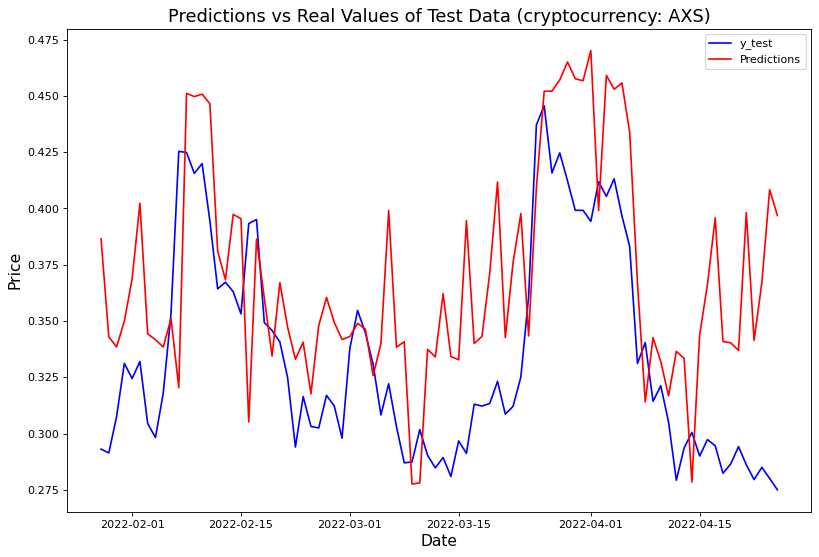

In [64]:
plt.figure(figsize = (12,8), dpi = 80)
plt.plot(results2['Date'], results2['y_test'], 'b', label = 'y_test')
plt.plot(results2['Date'], results2['Predictions'], 'r', label = 'Predictions')
plt.title ('Predictions vs Real Values of Test Data (cryptocurrency: AXS)', fontsize = 16, )
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.legend()

plt.show()

In [65]:
print("Train data MSE: ", mean_squared_error(y_train,predictions_train))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_train, predictions_train)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_train, predictions_train))))
print('R^2 Score', r2_score(y_train, predictions_train))

print ("--------------------------------------------------------------")
print("Test data MSE: ", mean_squared_error(y_test,predictions))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))
print('R^2 Score', r2_score(y_test, predictions))

Train data MSE:  2.962417451891239e-07
Mean Absolute Error - MAE : 0.0004028127525367284
Root Mean squared Error - RMSE : 0.0005442809432536876
R^2 Score 0.9999970041473167
--------------------------------------------------------------
Test data MSE:  0.00273117194226026
Mean Absolute Error - MAE : 0.04382487964591473
Root Mean squared Error - RMSE : 0.05226061559396579
R^2 Score -0.23710726824271067


# AXS - since January 2022  <a name="jan2022"></a>

# Model 1: LSTM <a name="lstm3"></a>

In [66]:
data4 = axs.copy()
data4.reset_index(inplace = True)
data4 = data4[data4['Date'] >= '2022-01-01']
data4.set_index('Date', inplace = True)
print("Total data for prediction: ",data4.shape[0])

Total data for prediction:  115


In [67]:
hist = []
target = []
length = 7

for i in range(len(data4)-length):
    t = data4['close']
    v = data4[['close','volume', 'BTC_closeprice','spread', 'volatility', 'close_off_high', 'EUR/USD_close']]
    x = v[i:i+length]
    y = t[i+length]
    hist.append(x)
    target.append(y)

In [68]:
print(len(hist[0]))
print(len(hist))
print(len(target))

7
108
108


In [69]:
#convert list to array
hist = np.array(hist)
target = np.array(target)

In [70]:
target = target.reshape(-1,1)
target.shape

(108, 1)

In [71]:
training_size = int(len(data4)*0.8)

X_train = hist[:training_size,:]
X_test = hist[training_size:,:]

y_train = target[:training_size]
y_test = target[training_size:]

In [72]:
X_train.shape

(92, 7, 7)

In [73]:
model4 = tf.keras.Sequential()

model4.add(layers.LSTM(units=20, activation = 'relu', return_sequences=True,
                  input_shape=(7,7), dropout = 0.2))

model4.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model4.add(layers.LSTM(units=32, activation = 'relu', dropout=0.2))

#model.add(layers.LSTM(units=55, return_sequences = True, dropout = 0.2))

#model.add(layers.LSTM(units = 80, activation = 'relu', dropout = 0.2))

model4.add(layers.Dense(units=1))

model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 7, 20)             2240      
                                                                 
 lstm_7 (LSTM)               (None, 7, 32)             6784      
                                                                 
 lstm_8 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 17,377
Trainable params: 17,377
Non-trainable params: 0
_________________________________________________________________


In [74]:
model4.compile(optimizer='adam', loss='mean_squared_error')

In [75]:
history = model4.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, shuffle = False)

Epoch 1/30
3/3 [==============================] - 4s 411ms/step - loss: 0.1220 - val_loss: 0.1246
Epoch 2/30
3/3 [==============================] - 0s 33ms/step - loss: 0.1006 - val_loss: 0.1050
Epoch 3/30
3/3 [==============================] - 0s 27ms/step - loss: 0.0816 - val_loss: 0.0823
Epoch 4/30
3/3 [==============================] - 0s 25ms/step - loss: 0.0606 - val_loss: 0.0564
Epoch 5/30
3/3 [==============================] - 0s 24ms/step - loss: 0.0389 - val_loss: 0.0300
Epoch 6/30
3/3 [==============================] - 0s 22ms/step - loss: 0.0188 - val_loss: 0.0087
Epoch 7/30
3/3 [==============================] - 0s 22ms/step - loss: 0.0077 - val_loss: 0.0014
Epoch 8/30
3/3 [==============================] - 0s 22ms/step - loss: 0.0108 - val_loss: 0.0020
Epoch 9/30
3/3 [==============================] - 0s 23ms/step - loss: 0.0103 - val_loss: 0.0014
Epoch 10/30
3/3 [==============================] - 0s 25ms/step - loss: 0.0058 - val_loss: 0.0041
Epoch 11/30
3/3 [===========

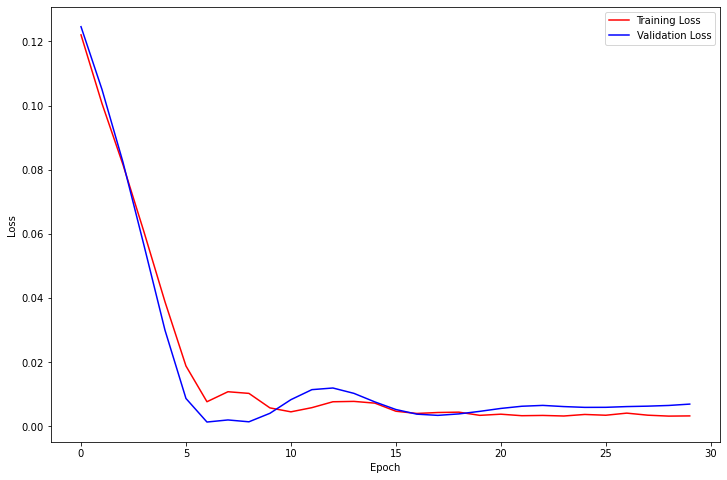

In [76]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_count = range(len(loss))
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r', label='Training loss')
plt.plot(epoch_count, val_loss, 'b', label='Validation loss')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [77]:
pred_test = model4.predict(X_test)
pred_train = model4.predict (X_train)

In [78]:
results = np.concatenate((y_test, pred_test), axis=1)
results = pd.DataFrame(results, columns = ['y_test', 'Predictions'])
a = data4['close'].tail(len(pred_test))
a = list(a.index)
results['Date'] = a
results['Date'] = pd.to_datetime(results['Date'])
results.tail()

,y_test,Predictions,Date
11,0.279568,0.284031,2022-04-21
12,0.284981,0.285216,2022-04-22
13,0.280089,0.286043,2022-04-23
14,0.275019,0.286183,2022-04-24
15,0.266291,0.287856,2022-04-25


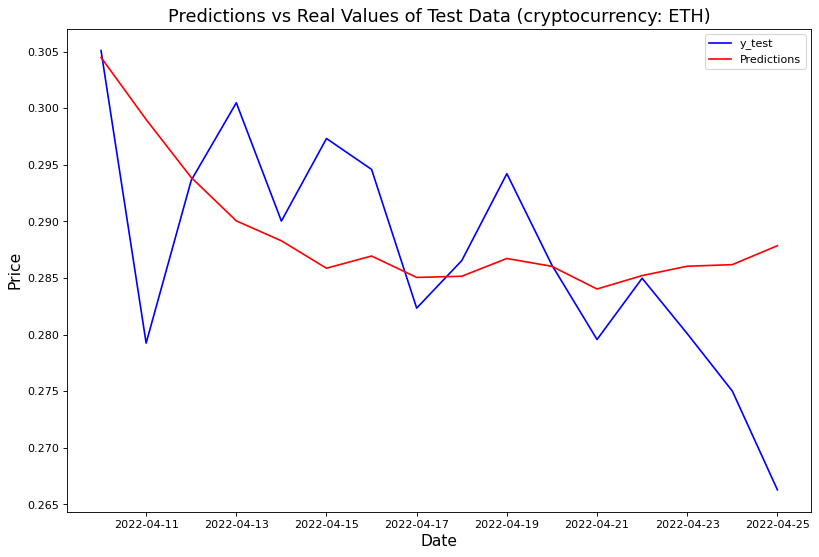

In [79]:
plt.figure(figsize = (12,8), dpi = 80)
plt.plot(results['Date'], results['y_test'], 'b', label = 'y_test')
plt.plot(results['Date'], results['Predictions'], 'r', label = 'Predictions')
plt.title ('Predictions vs Real Values of Test Data (cryptocurrency: ETH)', fontsize = 16,)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.legend()

plt.show()

In [80]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,pred_train)))
print("Train data MSE: ", mean_squared_error(y_train,pred_train))
print("Train data MAE: ", mean_absolute_error(y_train,pred_train))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,pred_test)))
print("Test data MSE: ", mean_squared_error(y_test,pred_test))
print("Test data MAE: ", mean_absolute_error(y_test,pred_test))

Train data RMSE:  0.06343288206568423
Train data MSE:  0.004023730527159004
Train data MAE:  0.046167210127609055
-------------------------------------------------------------------------------------
Test data RMSE:  0.009362878229557097
Test data MSE:  8.766348874151425e-05
Test data MAE:  0.006684638841890651


In [81]:
print("Train data R2 score:", r2_score(y_train, pred_train))
print("Test data R2 score:", r2_score(y_test, pred_test))

Train data R2 score: -0.18468584617981865
Test data R2 score: 0.08929343382055266


# Model 2: XGBoost Regressor   <a name="xgboost3"></a>

In [82]:
data5= axs.copy()
data5.reset_index(inplace = True)
data5 = data5[data5['Date'] >= '2022-01-01']
data5.set_index('Date', inplace = True)
print("Total data for prediction: ",data5.shape[0])

Total data for prediction:  115


In [83]:
training_size=int(len(data5)*0.80)
test_size=len(data5)-training_size
train_data,test_data=data5.iloc[:training_size,:],data5.iloc[training_size:,:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (92, 8)
test_data:  (23, 8)


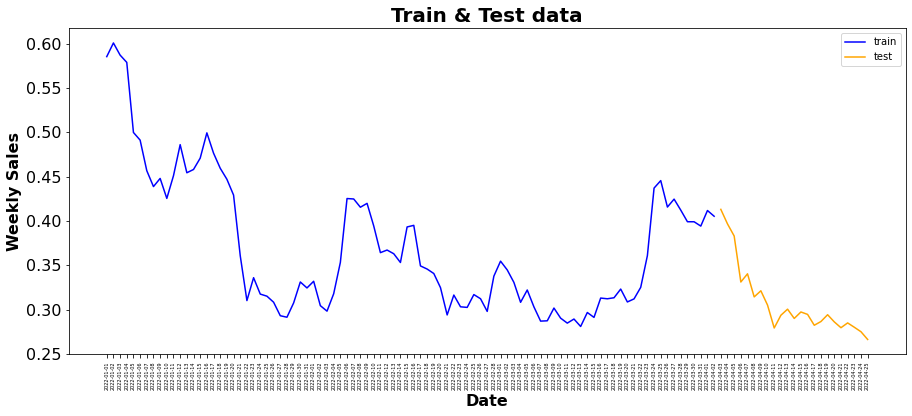

In [84]:
data5.reset_index(inplace = True)
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = data5['Date'][:training_size], y = data5['close'][:training_size], color = 'blue')
sns.lineplot(x = data5['Date'][training_size:], y = data5['close'][training_size:], color = 'orange')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=5)
plt.xticks(rotation = 'vertical')
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [85]:
data5.set_index('Date', inplace = True)

In [86]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step), :]   
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [87]:
time_step = 7
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (84, 7, 8)
y_train:  (84,)
X_test:  (15, 7, 8)
y_test (15,)


In [88]:
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [89]:
model5 = XGBRegressor(n_estimators=1000, random_state = 1, eta = 0.2)
model5.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.200000003, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
             reg_alpha=0, ...)

In [90]:
predictions = model5.predict(X_test).reshape(-1,1)
y_test = y_test.reshape(-1,1)


predictions_train = model5.predict(X_train).reshape(-1,1)
y_train = y_train.reshape(-1,1)

In [91]:
results2 = np.concatenate((y_test, predictions), axis = 1)
results2 = pd.DataFrame(results2, columns = ['y_test', 'Predictions'])
a = data5['close'].tail(len(predictions))
a = list(a.index)
results2['Date'] = a
results2['Date'] = pd.to_datetime(results2['Date'])
results2.tail()

,y_test,Predictions,Date
10,0.286135,0.322362,2022-04-21
11,0.279568,0.309359,2022-04-22
12,0.284981,0.298920,2022-04-23
13,0.280089,0.296765,2022-04-24
14,0.275019,0.300669,2022-04-25


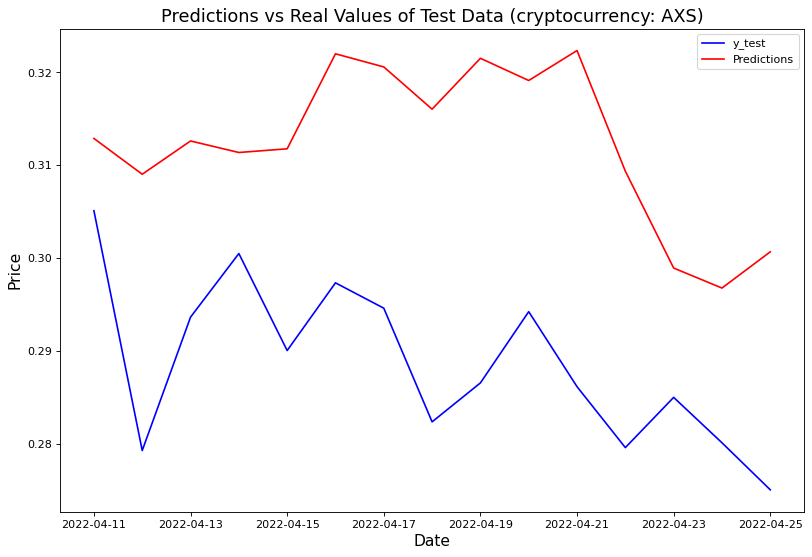

In [92]:
plt.figure(figsize = (12,8), dpi = 80 )
plt.plot(results2['Date'], results2['y_test'], 'b', label = 'y_test')
plt.plot(results2['Date'], results2['Predictions'], 'r', label = 'Predictions')
plt.title ('Predictions vs Real Values of Test Data (cryptocurrency: AXS)', fontsize = 16, )
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.legend()

plt.show()

In [93]:
print("Train data MSE: ", mean_squared_error(y_train,predictions_train))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_train, predictions_train)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_train, predictions_train))))
print('R^2 Score', r2_score(y_train, predictions_train))

print ("--------------------------------------------------------------")
print("Test data MSE: ", mean_squared_error(y_test,predictions))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))
print('R^2 Score', r2_score(y_test, predictions))

Train data MSE:  1.4543166871503572e-07
Mean Absolute Error - MAE : 0.0002995931077637286
Root Mean squared Error - RMSE : 0.0003813550428603714
R^2 Score 0.9999593877136975
--------------------------------------------------------------
Test data MSE:  0.0006330091192430502
Mean Absolute Error - MAE : 0.023717001260923628
Root Mean squared Error - RMSE : 0.025159672478850956
R^2 Score -7.851591644312718


# Predictions for the next two days using the best model <a name="predictions"></a>

In [94]:
#Importing the dataset with the updated data
#Use just the 7 past rows, because our model is predicting based on this sliding window
predictions = pd.read_csv('test_AXS.csv', index_col = 'Date')

In [95]:
predictions.tail(7)

,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close,BTC_closeprice
Date,,,,,,,,
2022-05-02,0.186536,0.039453,0.135212,0.051317,0.051119,0.909747,0.017292,0.424526
2022-05-03,0.179666,0.038092,0.135463,0.045644,0.046545,0.925374,0.002644,0.409090
2022-05-04,0.206229,0.056792,0.164004,0.126899,0.176261,0.987381,0.013245,0.447695
2022-05-05,0.178856,0.073006,0.146049,0.153446,0.187041,0.730404,0.064389,0.385798
2022-05-06,0.175594,0.041692,0.137632,0.036095,0.034521,0.972671,0.019347,0.375210
2022-05-07,0.177392,0.034856,0.060965,0.044031,0.048271,0.968558,0.019347,0.364529
2022-05-08,0.187741,0.076217,0.094765,0.080940,0.106023,0.954630,0.019347,0.339257


In [96]:
predictions1 = predictions.tail(7)
predictions1 = np.array(predictions1)

In [97]:
x_input=predictions1[len(predictions1)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

output9=[]
n_steps=7
i=0
pred_days = 1


In [98]:
while(i<pred_days):
    
    if(len(temp_input)>time_step):        
        x_input=np.array(temp_input[i:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = model3.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[i:]
       
        output9.extend(yhat.tolist())
        i=i+1
        
print("Output of predicted next days: ", len(output9))

0 day input [0.18653632 0.03945296 0.13521183 0.0513173  0.05111895 0.90974677
 0.01729174 0.42452624 0.17966597 0.0380923  0.13546278 0.04564402
 0.04654522 0.92537412 0.00264389 0.40909027 0.20622895 0.05679239
 0.16400424 0.12689927 0.17626124 0.98738064 0.01324543 0.44769468
 0.17885571 0.07300605 0.14604865 0.15344634 0.18704145 0.73040364
 0.06438862 0.38579757 0.17559393 0.04169187 0.13763193 0.0360955
 0.03452108 0.9726709  0.01934702 0.37521027 0.17739179 0.03485645
 0.06096531 0.04403093 0.04827107 0.96855821 0.01934702 0.36452883
 0.18774095 0.07621734 0.09476541 0.08093978 0.10602259 0.95462961
 0.01934702 0.3392574 ]
0 day output [0.3834712]
Output of predicted next days:  1


In [99]:
output9  #predicted closing price for May 9th, 2022 (Monday)

[0.38347119092941284]

In [100]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[1 2 3 4 5 6 7]
[8]


In [101]:
# Inserting the prediction for the row May 9th, 2022 --> using new predicted value + data from May 8th 2022 for the other variables 

In [102]:
a = predictions.tail(1).copy()
a.reset_index(inplace = True)
a

,Date,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close,BTC_closeprice
0,2022-05-08,0.187741,0.076217,0.094765,0.08094,0.106023,0.95463,0.019347,0.339257


In [103]:
a.at[0,'Date']='2022-05-09'
a.at[0,'close']= output9[0]
a.set_index('Date', inplace = True)
a

,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close,BTC_closeprice
Date,,,,,,,,
2022-05-09,0.383471,0.076217,0.094765,0.08094,0.106023,0.95463,0.019347,0.339257


In [104]:
final_predictions = pd.concat([predictions, a], axis=0, join='outer')

In [105]:
#Get the predicted denormalized closing price using MinMaxScaler formula
intermediate_result = ((160.359268-0.135104)*output9[0])+0.135104

print ("The predicted closing price for AXS on May 9th, 2022 is ", intermediate_result, "USD")

The predicted closing price for AXS on May 9th, 2022 is  61.576454984749546 USD


# Final Predictions<a name="finalpredictions"></a>

In [106]:
final_predictions.tail(7)

,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close,BTC_closeprice
Date,,,,,,,,
2022-05-03,0.179666,0.038092,0.135463,0.045644,0.046545,0.925374,0.002644,0.409090
2022-05-04,0.206229,0.056792,0.164004,0.126899,0.176261,0.987381,0.013245,0.447695
2022-05-05,0.178856,0.073006,0.146049,0.153446,0.187041,0.730404,0.064389,0.385798
2022-05-06,0.175594,0.041692,0.137632,0.036095,0.034521,0.972671,0.019347,0.375210
2022-05-07,0.177392,0.034856,0.060965,0.044031,0.048271,0.968558,0.019347,0.364529
2022-05-08,0.187741,0.076217,0.094765,0.080940,0.106023,0.954630,0.019347,0.339257
2022-05-09,0.383471,0.076217,0.094765,0.080940,0.106023,0.954630,0.019347,0.339257


In [107]:
final_predictions1 = final_predictions.tail(7)
final_predictions1 = np.array(final_predictions1)

In [108]:
x_input=(final_predictions1[len(final_predictions1)-(time_step*time_step):]).reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

output10=[]
n_steps=7
i=0
pred_days = 1

In [109]:
while(i<pred_days):
    
    if(len(temp_input)>time_step):        
        x_input=np.array(temp_input[i:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = model3.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[i:]
       
        output10.extend(yhat.tolist())
        i=i+1
        
print("Output of predicted next days: ", len(output10))

0 day input [0.17966597 0.0380923  0.13546278 0.04564402 0.04654522 0.92537412
 0.00264389 0.40909027 0.20622895 0.05679239 0.16400424 0.12689927
 0.17626124 0.98738064 0.01324543 0.44769468 0.17885571 0.07300605
 0.14604865 0.15344634 0.18704145 0.73040364 0.06438862 0.38579757
 0.17559393 0.04169187 0.13763193 0.0360955  0.03452108 0.9726709
 0.01934702 0.37521027 0.17739179 0.03485645 0.06096531 0.04403093
 0.04827107 0.96855821 0.01934702 0.36452883 0.18774095 0.07621734
 0.09476541 0.08093978 0.10602259 0.95462961 0.01934702 0.3392574
 0.38347119 0.07621734 0.09476541 0.08093978 0.10602259 0.95462961
 0.01934702 0.3392574 ]
0 day output [0.39361548]
Output of predicted next days:  1


In [110]:
print ("The predicted normalized closing price for AXS on May 10th, 2022 is ", output10[0])

The predicted normalized closing price for AXS on May 10th, 2022 is  0.3936154842376709


In [111]:
#Get the predicted denormalized closing price using MinMaxScaler formula
final_result = ((160.359268-0.135104)*output10[0])+0.135104

print ("The predicted closing price for AXS on May 10th, 2022 is ", final_result, "USD")

The predicted closing price for AXS on May 10th, 2022 is  63.201815899435985 USD
